<a href="https://colab.research.google.com/github/sonakshisharan/Machine_Learning/blob/main/Hand_Gestures_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [ ]:
df = pd.read_csv("sign_mnist_train.csv")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

print(train_data.shape)
train_data.head()

print(test_data.shape)
test_data.head()


(9676, 785)
(2419, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
468,23,208,210,212,213,213,216,216,216,217,...,248.0,248.0,248.0,248.0,249.0,248.0,248.0,247.0,247.0,246.0
11619,24,158,159,161,163,163,164,165,166,166,...,188.0,188.0,187.0,186.0,185.0,184.0,183.0,182.0,181.0,179.0
538,3,94,113,130,140,142,149,157,161,166,...,81.0,46.0,52.0,20.0,17.0,60.0,30.0,2.0,32.0,51.0
5265,1,33,76,77,84,88,105,131,147,153,...,112.0,82.0,54.0,13.0,5.0,1.0,28.0,37.0,48.0,49.0
7484,8,136,137,139,140,140,141,141,142,144,...,49.0,15.0,143.0,175.0,166.0,165.0,164.0,162.0,160.0,156.0


In [ ]:
y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

In [ ]:
unique_labels = y_train.unique()
unique_labels = np.sort(unique_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [ ]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

y_train[:2]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [ ]:
def preprocess_image(x):

    """
    we know that the pixcel values lies between 0-255 but it is obsearved that models performs exceptionally well if we scale pixel values
    between 0-1"""
    x = x/255
    x = x.reshape(-1,28,28,1) # convertin it into 28 x 28 gray scaled image

    return x

In [ ]:
train_x = preprocess_image(train_data.values)
test_x = preprocess_image(test_data.values)

In [ ]:
def show_images(images,labels):
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            ax[i,j].imshow(images[k] , cmap='gray')
            ax[i,j].set_title(str(unique_labels[np.argmax(y_train[k])]))
            k = k+1;
    plt.tight_layout()

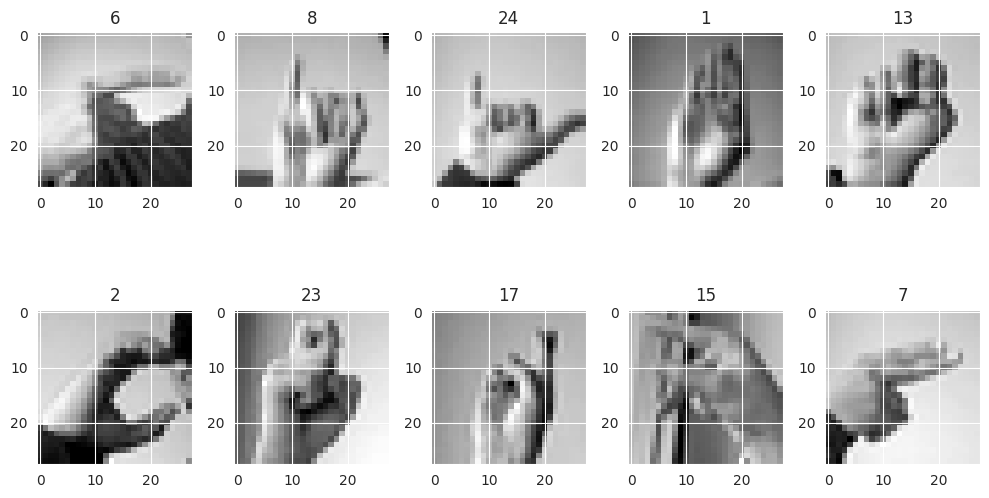

In [ ]:
#let's see first 10 images from training set
show_images(train_x,y_train)

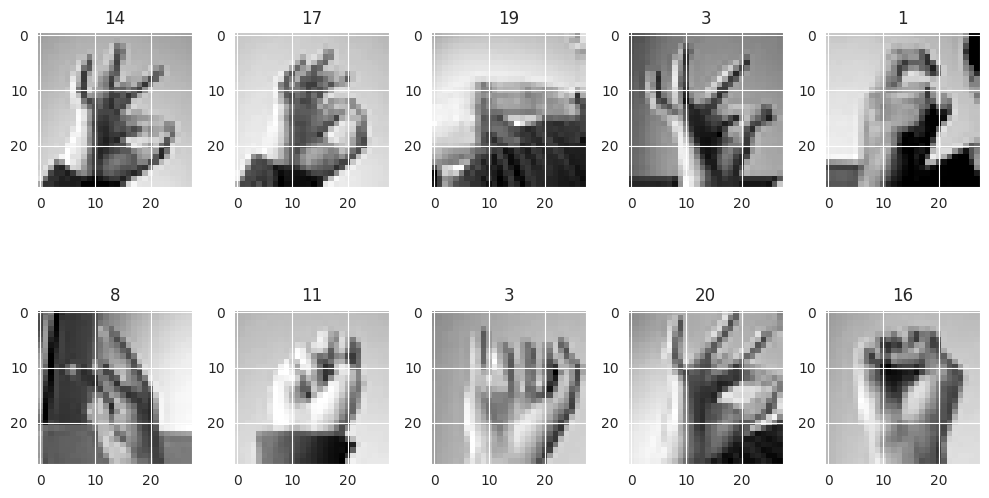

In [ ]:
#let's visualize test images as well
show_images(test_x,y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)

In [ ]:
def build_model(hp):
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=75, max_value=200, step=25),
        kernel_size=(3,3),
        activation='relu',

        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=50, max_value=125, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),

    keras.layers.Dropout(
        rate = hp.Choice('drop_1_rate', values = [0.1,0.5])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),


    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=25, max_value=75, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    ),
    keras.layers.Dropout(
        rate = hp.Choice('drop_2_rate', values = [0.1,0.3])
    ),
    keras.layers.Dense(24, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model


In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ASLdetection1")

In [ ]:
tuner_search.search(train_x,y_train,epochs=5,validation_data = (test_x, y_test))

Trial 5 Complete [00h 03m 24s]
val_accuracy: 0.04423315450549126

Best val_accuracy So Far: 0.04423315450549126
Total elapsed time: 00h 22m 18s


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0] #this will give us the best tuned model

In [ ]:
from kerastuner import RandomSearch

# Define the RandomSearch tuner
tuner_search = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='output',
    project_name="ASLdetection1"
)

# Start the search
tuner_search.search(train_x, y_train, epochs=5, validation_data=(test_x, y_test))

# Get the best tuned model
model = tuner_search.get_best_models(num_models=1)[0]


Reloading Tuner from output/ASLdetection1/tuner0.json


In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
history = model.fit(datagen.flow(train_x,y_train, batch_size = 128)
                    ,epochs = 20
                    , validation_data = (test_x, y_test)
                    , callbacks = [lr_reduction])

Epoch 1/20
76/76 [==============================] - 77s 944ms/step - loss: nan - accuracy: 0.0396 - val_loss: nan - val_accuracy: 0.0442 - lr: 0.0100
Epoch 2/20
76/76 [==============================] - 61s 805ms/step - loss: nan - accuracy: 0.0396 - val_loss: nan - val_accuracy: 0.0442 - lr: 0.0100
Epoch 3/20
76/76 [==============================] - 62s 811ms/step - loss: nan - accuracy: 0.0396 - val_loss: nan - val_accuracy: 0.0442 - lr: 0.0100
Epoch 4/20
76/76 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0396
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
76/76 [==============================] - 59s 777ms/step - loss: nan - accuracy: 0.0396 - val_loss: nan - val_accuracy: 0.0442 - lr: 0.0100
Epoch 5/20
76/76 [==============================] - 61s 796ms/step - loss: nan - accuracy: 0.0396 - val_loss: nan - val_accuracy: 0.0442 - lr: 0.0050
Epoch 6/20
76/76 [==============================] - 59s 772ms/step - loss: nan - accuracy: 0.03

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 125)       1250      
                                                                 
 batch_normalization (Batch  (None, 26, 26, 125)       500       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 125)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 125)       140750    
                                                                 
 dropout (Dropout)           (None, 11, 11, 125)       0         
                                                                 
 batch_normalization_1 (Bat  (None, 11, 11, 125)       5

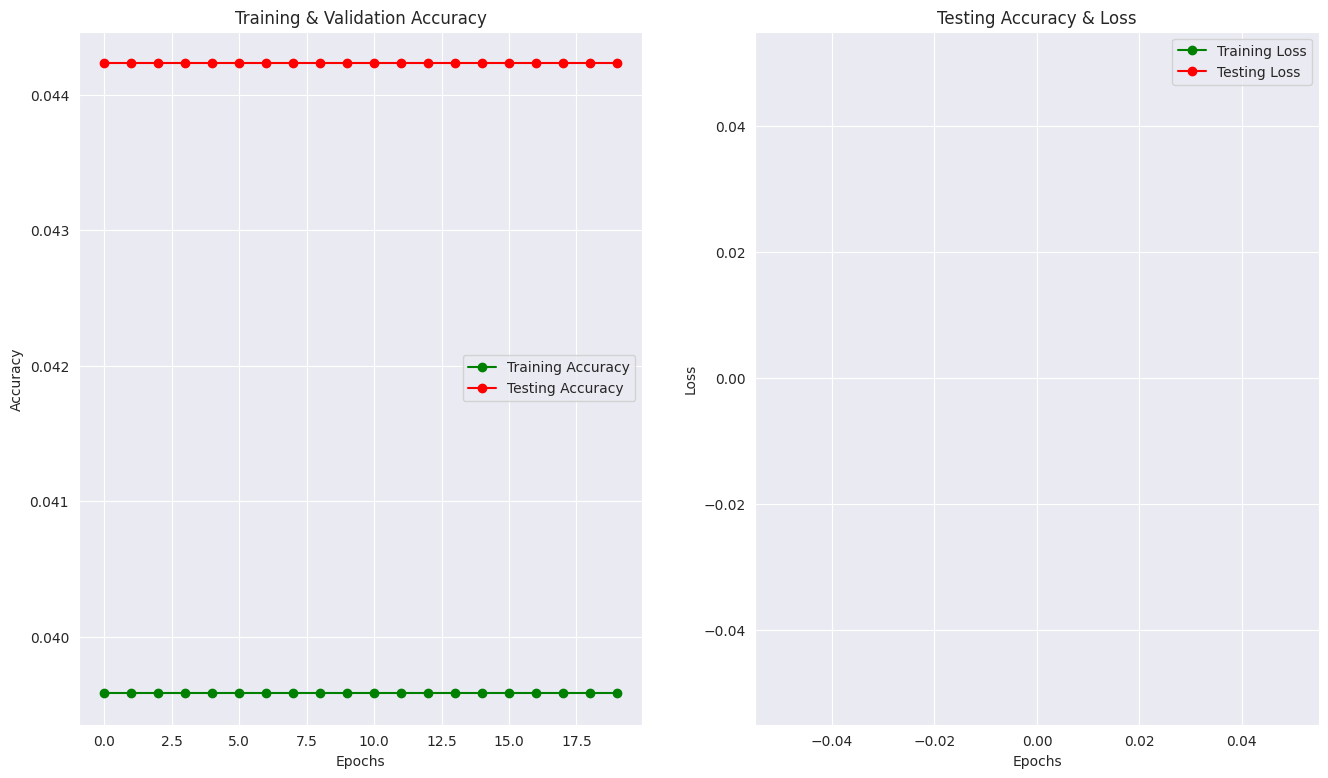

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

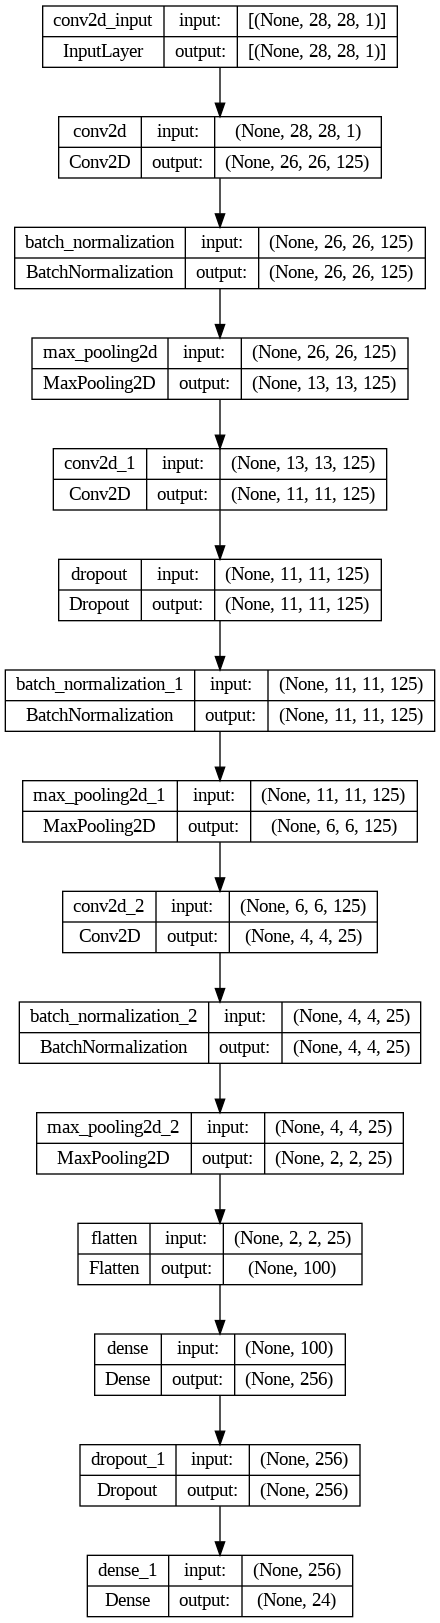

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
predictions = model.predict(test_x)

76/76 [==============================] - 3s 35ms/step


In [ ]:
def predictions_to_labels(pred):
    labels =[]
    for p in pred:
        labels.append(unique_labels[np.argmax(p)])
    return labels

In [ ]:
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)

<Axes: >

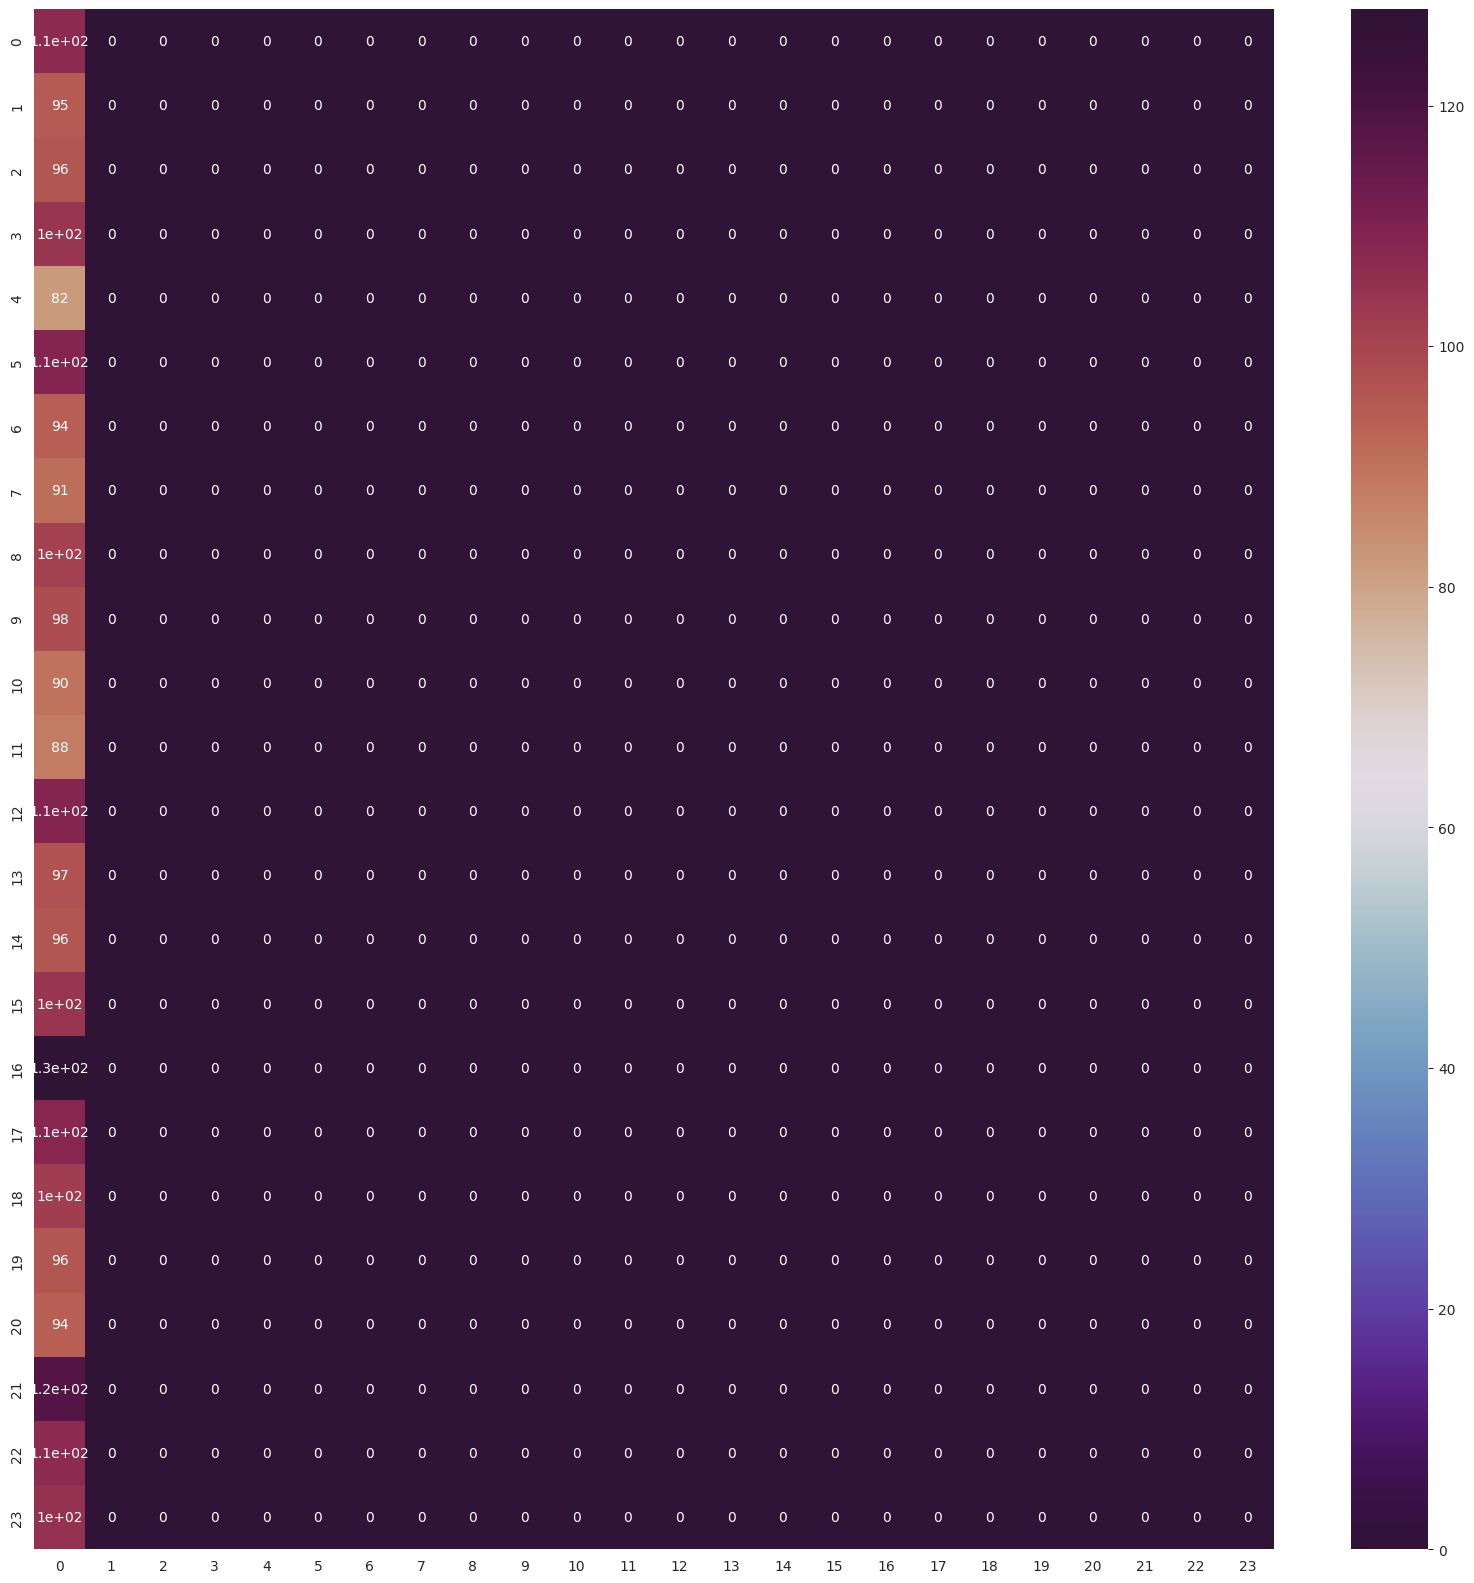

In [ ]:
cm= confusion_matrix(y_test_labels,y_pred_labels)
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True,cmap='twilight_shifted')